# Preliminaries

Importing python packages and setting display parameters

In [1]:
import numpy as np
import pandas as pd

import math as mt
import random as rnd
import statistics as stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import thesis_EAfunc as EAf
import thesis_visfunc as EAv

from deap import base, creator, tools

In [2]:
plt.style.use('bmh')
plt.rcParams.update({'figure.autolayout': True})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

# Fitness Landscape Definition

In [3]:
# Problem domain
x_min = -15
x_max = 15
y_min = -15
y_max = 15

# Known minimum
x_point = -6.01717
y_point = 9.06022

domain = (x_min, x_max, y_min, y_max)
point = (x_point, y_point)
img_size = (8.5, 4.25)

# Problem definition


def g_fun(x, y):
    mag = np.sqrt(x**2. + y**2.)
    val = -(50.*np.sinc(mag/np.pi) - mag)
    return val.item()


def f_fun(x, y):
    x_min = -6.01717
    y_min = 9.06022
    f_min = g_fun(x_min+11., y_min+9.) + g_fun(x_min-11.,
                                       y_min-3.) + g_fun(x_min+6., y_min-9.)
    tripsinc = g_fun(x+11., y+9.) + g_fun(x-11., y-3.) + g_fun(x+6., y-9.) - (f_min)
    return tripsinc

In [4]:
def evaluate(individual):
    x = individual[0]
    y = individual[1]
    fitness = f_fun(x,y)
    return (fitness,)

In [5]:
# Testing the minimum
print(f_fun(-6.01717, 9.06022))

0.0


In [6]:
# Testing the function
print(f_fun(-1., -1.), f_fun(-11., -9.), f_fun(11., 3.), f_fun(-6., 9.))

50.62059878583003 5.177364279021976 6.107247239602234 0.031278340140559635


# Running the Evolutionary Algorithm

## Setting the EA's parameters

In [7]:
# Algorithm parameters
# Number of replicates, and generations per experiment
rep_end = 1
gen_end = 5000

# Genes
gen_size = 2
# Population size
pop_size = 20
# Progeny and parents size
b_ratio = 3
par_size = b_ratio * pop_size

# Progeny parameters
## Crossover probability per gene
cx_pb = .5
## Mutation probability per gene
mut_pb = .5
## Mutation strength
sigma = 2.5

# Selection by tournament
# Tournament size parent selection
k_p=2
# Tournament size survivor selection
k_s=6

## Defining the EA elements

We define that the fitness is related to a minimizing problem, and that each individual is represented with a list of numbers

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

We start the DEAP toolset. At creation, each individual will have 2 genes of type "float" that are randomly initialized in the range [-15; 15].

In [9]:
toolbox = base.Toolbox()

In [10]:
toolbox.register("attr_float", rnd.uniform, -15, 15)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=gen_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

We add our landscape to the toolset, indicate that the mating will use a uniform crossover on a per-gene basis, that the mutation will be also on a per-gene basis with a value taken from a gaussian distribution, and that parent and survivor selections will use tournament selection.

In [11]:
toolbox.register("evaluate", evaluate)

toolbox.register("mate", tools.cxUniform, indpb=cx_pb)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=sigma, indpb=mut_pb)

toolbox.register("par_select", tools.selTournament, tournsize=k_p)
toolbox.register("sur_select", tools.selTournament, tournsize=k_s)

We define that for each generation we'll summarize the fitnesses with median, mean, standard deviation, and store the best and worst fitnesses in the generation.

In [12]:
stat = tools.Statistics(key=lambda ind: ind.fitness.values[0])

stat.register('med', stats.median)
stat.register('avg', stats.mean)
stat.register('std', stats.stdev)
stat.register('best', min)
stat.register('worst', max)

We invoque the data recording logbook.

In [13]:
logbook = tools.Logbook()

## Single Run of the EA Experiments
1 Experiment
L-> 1 Parameter set for the experiment.
>L-> 1 Replicate.
>>L-> The replicate is affected due to the randomness seed.

In [14]:
# starting seed
rnd.seed(42)

In [15]:
%%time
if __name__ == "__main__":
    for rep_n in range(rep_end):
        rep_seed = rnd.randint(0,999)
        rnd.seed(rep_seed)
        # We initialize the population and evaluate the individuals' fitnesses
        pop = toolbox.population(n=pop_size)
        fitnesses = toolbox.map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # We start the logbook
        record = stat.compile(pop)
        logbook.record(rep=rep_n+1, seed=rep_seed, gen=0, **record)

        for gen_n in range(gen_end):
            # Select Parents and clone them as base for offsprings
            parents = toolbox.par_select(pop, par_size)
            offspring = [toolbox.clone(ind) for ind in pop]

            # Aplly crossover    
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

            # Apply mutation
            for mutant in offspring:
                toolbox.mutate(mutant)
                del mutant.fitness.values

            fitnesses = toolbox.map(toolbox.evaluate, offspring)
            for ind, fit in zip(offspring, fitnesses):
                ind.fitness.values = fit

            pop = toolbox.sur_select((pop+offspring), pop_size)

            record = stat.compile(pop)
            logbook.record(rep=rep_n+1, seed=rep_seed, gen=gen_n+1, **record)

Wall time: 23.2 s


### Data Analysis

We transform the records into a Data Frame

In [18]:
pop_records = [record for record in logbook]
fitness_res = pd.DataFrame.from_dict(pop_records)

#### Fitness development

[]

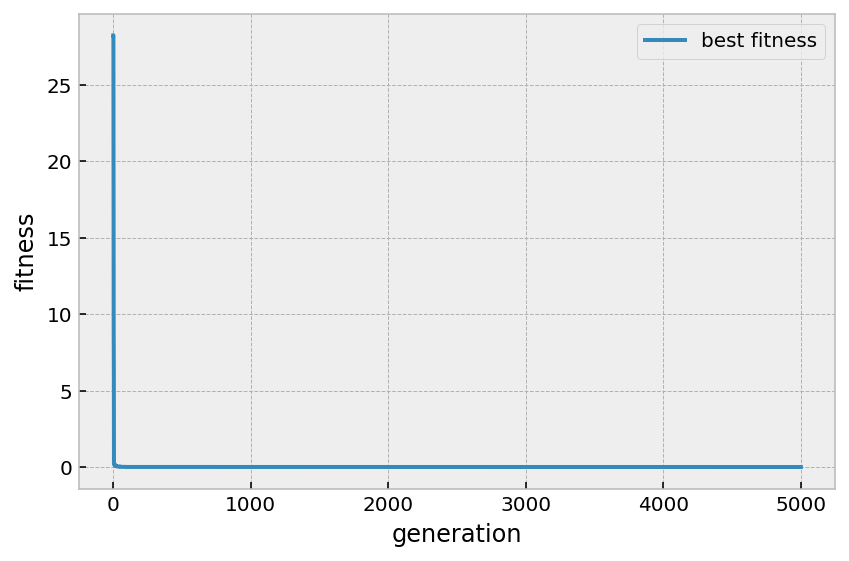

In [19]:
fig, ax = plt.subplots()
ax = sns.lineplot(x='gen', y='best', data=fitness_res, label='best fitness')
ax.set(xlabel='generation', ylabel='fitness')
ax.plot()

## 100 Executions of the EA
1 Experiment
>L-> 1 Parameter set for the experiment.
>>L-> 100 Replicate.
>>>L-> Each replicate is different due to randomness effects.

### Changing parameters

In [20]:
# Restarting seed
np.random.seed(42)

# Algorithm parameters
# Number of replicates
rep_end = 30

### Execution

In [21]:
%%time
logbook.clear()

if __name__ == "__main__":
    for rep_n in range(rep_end):
        rep_seed = rnd.randint(0,999)
        rnd.seed(rep_seed)
        # We initialize the population and evaluate the individuals' fitnesses
        pop = toolbox.population(n=pop_size)
        fitnesses = toolbox.map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # We start the logbook
        record = stat.compile(pop)
        logbook.record(rep=rep_n+1, seed=rep_seed, gen=0, **record)

        for gen_n in range(gen_end):
            # Select Parents and clone them as base for offsprings
            parents = toolbox.par_select(pop, par_size)
            offspring = [toolbox.clone(ind) for ind in pop]

            # Aplly crossover    
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

            # Apply mutation
            for mutant in offspring:
                toolbox.mutate(mutant)
                del mutant.fitness.values

            fitnesses = toolbox.map(toolbox.evaluate, offspring)
            for ind, fit in zip(offspring, fitnesses):
                ind.fitness.values = fit

            pop = toolbox.sur_select((pop+offspring), pop_size)

            record = stat.compile(pop)
            logbook.record(rep=rep_n+1, seed=rep_seed, gen=gen_n+1, **record)

Wall time: 21min 37s


### Data Analysis

We transform the records into a Data Frame

In [24]:
pop_records = [record for record in logbook]
fitness_res = pd.DataFrame.from_dict(pop_records)

We filter the values of the last generation

In [33]:
last_gen = fitness_res['gen'].max()
query = (fitness_res['gen'] == last_gen)
fin_fit_res = fitness_res[query]

31

Top 10 best (lowest-fitness) individuals

In [40]:
fin_fit_res.sort_values(by=['best']).head(10)

,avg,best,gen,med,rep,seed,std,worst
90017,9.926543e-08,9.926543e-08,5000,9.926543e-08,17,131,0.00000,9.926543e-08
45008,1.012549e-07,1.012549e-07,5000,1.012549e-07,8,554,0.00000,1.012549e-07
50009,1.226753e-01,1.471475e-07,5000,1.471475e-07,9,914,0.54862,2.453502e+00
25004,1.799357e-07,1.799357e-07,5000,1.799357e-07,4,989,0.00000,1.799357e-07
15002,1.975666e-07,1.975666e-07,5000,1.975666e-07,2,333,0.00000,1.975666e-07
110021,3.016173e-07,3.016173e-07,5000,3.016173e-07,21,653,0.00000,3.016173e-07
95018,3.054616e-07,3.054616e-07,5000,3.054616e-07,18,292,0.00000,3.054616e-07
40007,3.510268e-07,3.510268e-07,5000,3.510268e-07,7,141,0.00000,3.510268e-07
140027,5.049444e-07,5.049444e-07,5000,5.049444e-07,27,388,0.00000,5.049444e-07
5000,5.848231e-07,5.848231e-07,5000,5.848231e-07,1,654,0.00000,5.848231e-07


Top 10 best (highest-fitness) individuals

In [41]:
fin_fit_res.sort_values(by=['best'], ascending=False).head(10)

,avg,best,gen,med,rep,seed,std,worst
145028,6.084912,6.084912,5000,6.084912,28,624,0.000000,6.084912
115022,6.084910,6.084910,5000,6.084910,22,291,0.000000,6.084910
80015,6.084909,6.084909,5000,6.084909,15,493,0.000000,6.084909
30005,6.084909,6.084909,5000,6.084909,5,894,0.000000,6.084909
20003,5.113027,5.113027,5000,5.113027,3,627,0.000000,5.113027
150029,5.113027,5.113027,5000,5.113027,29,172,0.000000,5.113027
105020,5.113027,5.113027,5000,5.113027,20,244,0.000000,5.113027
65012,5.113026,5.113026,5000,5.113026,12,703,0.000000,5.113026
75014,5.903326,5.113026,5000,5.113026,14,525,3.534329,20.919025
100019,5.113026,5.113026,5000,5.113026,19,19,0.000000,5.113026


### Visualization

#### Aggregated results

In [77]:
fin_fit_best = fin_fit_res['best']
fin_fit_stdv = fin_fit_res['std']
type(fin_fit_best)

pandas.core.series.Series

[]

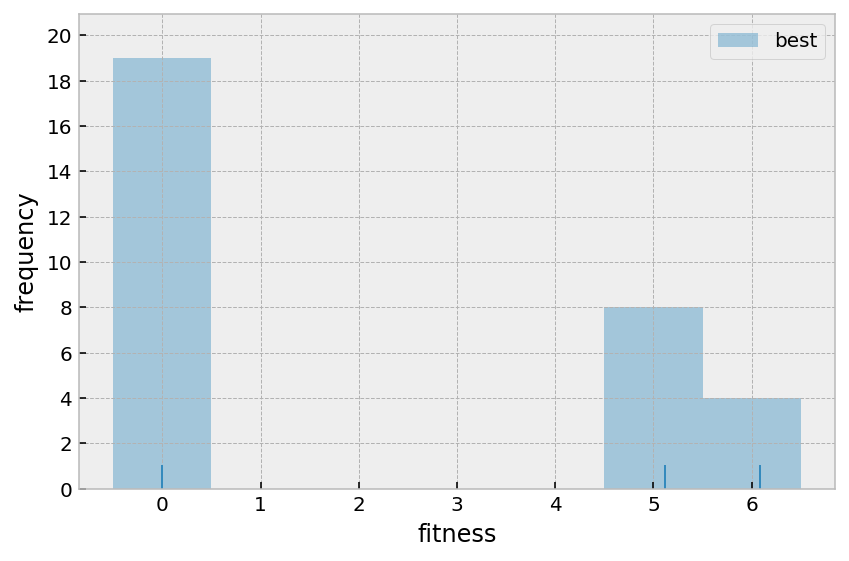

In [78]:
fig, ax = plt.subplots()
ax = sns.distplot(fin_fit_best, rug=True, kde=False, bins=7, hist_kws={'range':(-.5, 6.5)}, axlabel='fitness', label='best')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end+1, 2.0))
ax.set(ylabel='frequency', ylim=(None,end+1))
ax.legend()
ax.plot()

[]

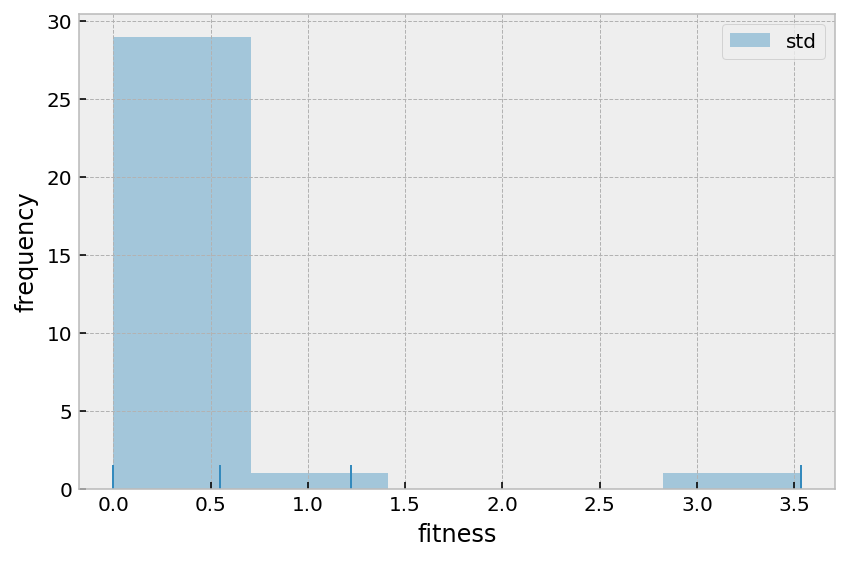

In [80]:
fig, ax = plt.subplots()
ax = sns.distplot(fin_fit_stdv, rug=True, kde=False, axlabel='fitness', label='std')
#start, end = ax.get_ylim()
#ax.yaxis.set_ticks(np.arange(start, end+1, 2.0))
ax.set(ylabel='frequency')
ax.legend()
ax.plot()

Wall time: 3min


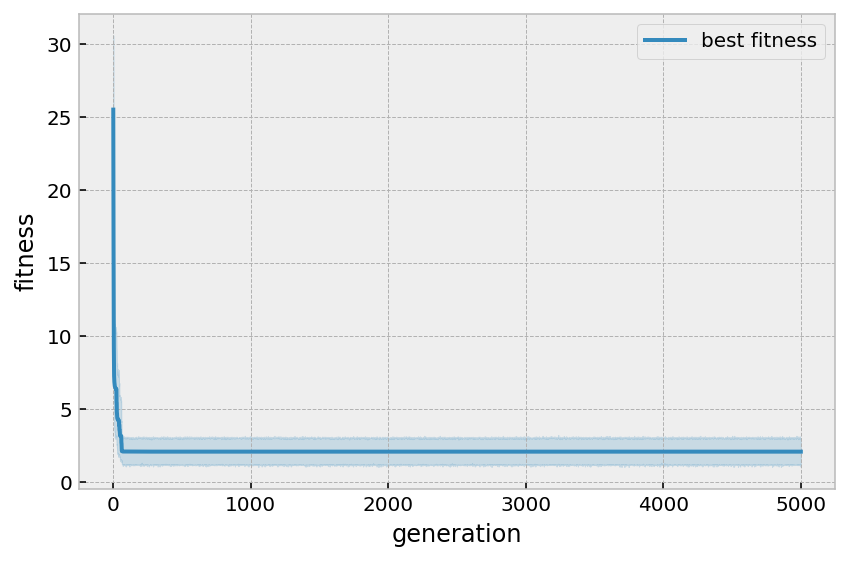

In [82]:
%%time
fig, ax = plt.subplots()
ax = sns.lineplot(x='gen', y='best', data=fitness_res, label='best fitness')
ax.set(xlabel='generation', ylabel='fitness')
ax.plot()

Wall time: 6.04 s


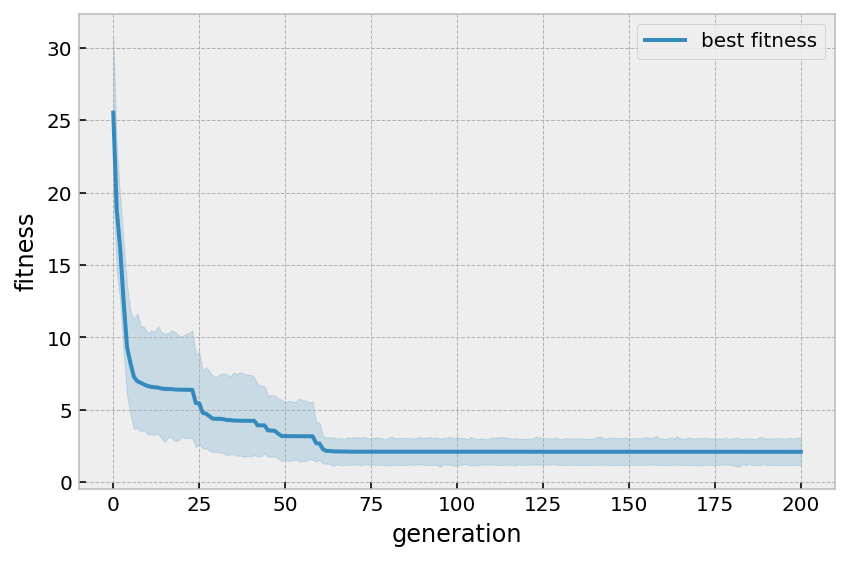

In [83]:
%%time
query = (fitness_res['gen'] <= 200)
fig, ax = plt.subplots()
ax = sns.lineplot(x='gen', y='best', data=fitness_res[query], label='best fitness')
ax.set(xlabel='generation', ylabel='fitness')
ax.plot()

Wall time: 23.8 s


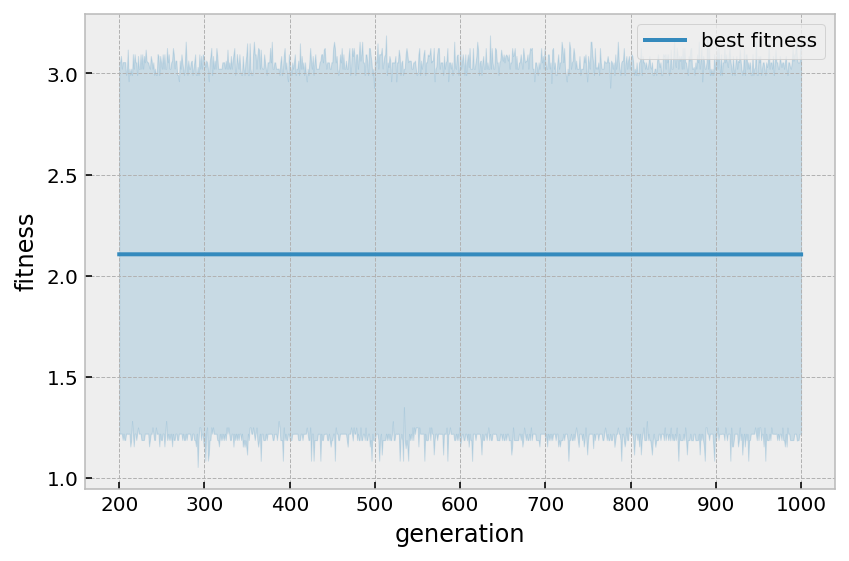

In [84]:
%%time
query = (fitness_res['gen'] >= 200) & (fitness_res['gen'] <= 1000)
fig, ax = plt.subplots()
ax = sns.lineplot(x='gen', y='best', data=fitness_res[query], label='best fitness')
ax.set(xlabel='generation', ylabel='fitness')
ax.plot()

Wall time: 14.7 s


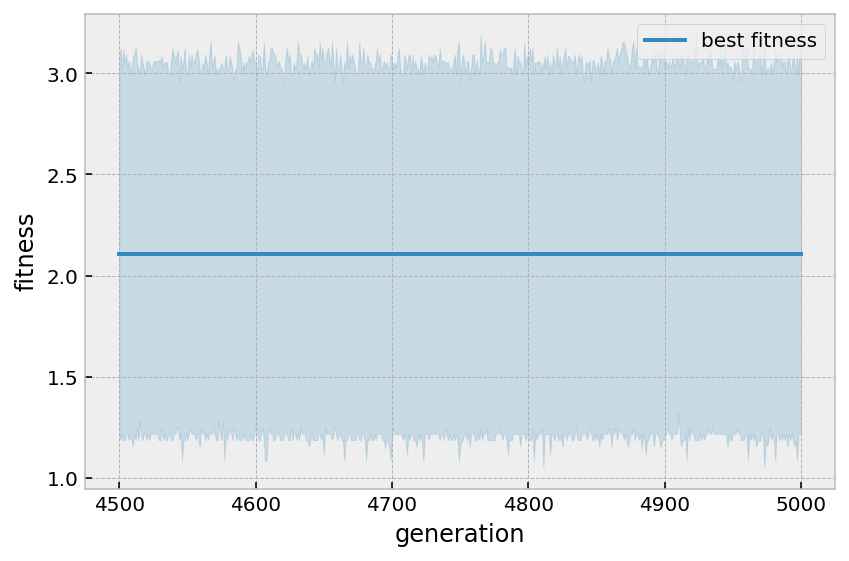

In [85]:
%%time
query = (fitness_res['gen'] >= 4500) & (fitness_res['gen'] <= 5000)
fig, ax = plt.subplots()
ax = sns.lineplot(x='gen', y='best', data=fitness_res[query], label='best fitness')
ax.set(xlabel='generation', ylabel='fitness')
ax.plot()